# Imports & Configuration

In [265]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Literal, List, Union
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Read data

In [411]:
METRIC_ID = "370018"
data = pd.read_csv("../../.data/метрики_торгового_эквайринга.csv", usecols=["datetime", METRIC_ID], parse_dates=["datetime"])

print(data.shape)
display(data.head())

(1725120, 2)


,datetime,370018
0,2020-01-01 00:00:00,NaN
1,2020-01-01 00:01:00,NaN
2,2020-01-01 00:02:00,NaN
3,2020-01-01 00:03:00,NaN
4,2020-01-01 00:04:00,NaN


In [404]:
data.dtypes

datetime    datetime64[ns]
317709             float64
dtype: object

In [405]:
data["datetime"].agg(["min", "max"])

min   2020-01-01 00:00:00
max   2023-04-12 23:59:00
Name: datetime, dtype: datetime64[ns]

# Build the model

In [10]:
%mkdir tsforecast

A subdirectory or file tsforecast already exists.


In [13]:
class Preprocessing:
    
    def __init__(self, roles: dict = {}, stages: List[Literal["extend_time", "interpolate"]] = ["extend_time", "interpolate"]) -> None:
        self.roles = {"datetime": "datetime", "value": "value", **roles}
        self.stages = stages

    def __call__(self, data: pd.DataFrame) -> pd.DataFrame:
        for stage in self.stages:
            method = getattr(self, stage)
            data = method(data)
        return data

    def extend_time(self, data: pd.DataFrame) -> pd.DataFrame:
        min_date, max_date = data[self.roles.get("datetime")].agg(["min", "max"])
        freq = int(data[self.roles.get("datetime")].diff().dropna().min().total_seconds() // 60)
        timeline = pd.date_range(start=min_date, end=max_date, freq="%sT" % freq)
        data = pd.DataFrame(data={self.roles.get("datetime"): timeline}) \
                 .merge(data.rename(columns=self.roles), on=self.roles.get("datetime"), how="left")
        return data

    def interpolate(self, data: pd.DataFrame) -> pd.DataFrame:
        data.loc[:, self.roles.get("value")] = data.loc[:, self.roles.get("value")] \
                                                   .interpolate(method="linear", limit_area="inside")
        return data


class TSModel:

    def __init__(self, h_size: int = 28, trend: Literal["linear", "polynomial"] = "linear", p_degree: int = 2,
                 roles: dict = {}, seasonal_type: Union[int, Literal["weekly", "daily"]] = "weekly", 
                 agg_f: Literal["mean", "median"] = "median", model_type: Literal["additive", "multiplicative"] = "additive") -> None:
        """
        :param h_size: размер обучающей выборки количестве значений (в днях)
        :param trend: тип детектируемого тренда ("linear" или "polynomial")
        :param p_degree: степень полинома в случае с полиномиальным трендом
        :param roles: названия колонок "datetime" и "value" в данных
        :param seasonal_type: тип максимальной сезонности (т.е. если присутствует и недельная, и дневная, то указывается недельная)
        :param agg_f: аггрегирующая функция при расчете сезонной компоненты
        :param model_type: тип модели (аддитивная или мультипликативная)
        """
        self.h_size = h_size
        self.trend = trend
        self.p_degree = p_degree
        self.roles = {"datetime": "datetime", "value": "value", **roles}
        self.seasonal_type = seasonal_type
        self.agg_f = agg_f
        self.model_type = model_type

    def fit_predict(self, data: pd.DataFrame, horizon: int = 1) -> pd.DataFrame:
        """
        :param data: исторические данные для настройки модели
        :param horizon: горизонт прогнозирования (в днях)
        """
        # настройка модели
        self.fit(data=data)

        # предсказание модели
        forecast, trend, seasonal = self.predict(horizon=horizon)
        return forecast, trend, seasonal

    def fit(self, data: pd.DataFrame) -> None:
        # определяем дискретность наших данных (в минутах)
        # и количество данных для обучения
        ts_1 = data[self.roles.get("datetime")].iloc[-1]
        ts_2 = data[self.roles.get("datetime")].iloc[-2]
        self.freq = int((ts_1 - ts_2).total_seconds() // 60)
        self.h_size_items = int(self.h_size * (24 * 60) // self.freq)

        # если размер истории меньше, чем выставленный параметр размера истории
        # то корректируем
        self.h_size_items = min(len(data), self.h_size_items)

        # настраиваем тренд
        fit_data = data.iloc[-self.h_size_items:, :]
        y = fit_data[self.roles.get("value")].values
        detrended = self.fit_trend_(y=y)

        # настроим сезонность
        self.fit_seasonal_(y=detrended)
        return
    
    def fit_trend_(self, y: list) -> None:
        # инициализируем модель линейной регрессии
        self.lr = LinearRegression()
        x = self.trend_features_generation_()
        self.lr.fit(x, y)
        trend = self.lr.predict(x)

        if self.model_type == "additive":
            detrended = y - trend
        elif self.model_type == "multiplicative":
            detrended = y / trend
        else:
            raise ValueError("Wrong model type.")
        
        return detrended
    
    def trend_features_generation_(self, horizon: int = None) -> np.ndarray:
        """
        :param horizon: количество точек для прогнозирования (не дней)
        """
        if horizon is None:
            x = np.reshape(range(self.h_size_items), newshape=(-1, 1))
        elif isinstance(horizon, int) and horizon > 0:
            x = np.reshape(range(horizon), newshape=(-1, 1))
            x += self.h_size_items
        else:
            raise ValueError("Wrong horizon value (has to be integer greater than 0)")

        if self.trend == "polynomial":
            pf = PolynomialFeatures(degree=self.p_degree, include_bias=False)
            x = pf.fit_transform(x)
        
        return x
    
    def fit_seasonal_(self, y: np.ndarray) -> None:
        
        if isinstance(self.seasonal_type, int):
            sl = self.seasonal_type
        elif isinstance(self.seasonal_type, str) and self.seasonal_type == "weekly":
            sl = 7 * 1440 // self.freq
        elif isinstance(self.seasonal_type, str) and self.seasonal_type == "daily":
            sl = 1440 // self.freq
        else:
            raise ValueError("Wrong seasonal component.")
        
        if self.h_size_items % sl:
            self.seasonal = np.insert(arr=y.astype("float"), obj=[0]*(sl - self.h_size_items % sl), values=np.nan)
            self.seasonal = np.reshape(self.seasonal, newshape=(sl, -1), order="F")
            agg_f = getattr(np, "nan" + self.agg_f)
        else:
            self.seasonal = np.reshape(y, newshape=(sl, -1), order="F")
            agg_f = getattr(np, self.agg_f)
            
        self.seasonal = agg_f(self.seasonal, axis=1)
        return
    
    def predict(self, horizon: int = 1) -> pd.DataFrame:
        """
        :param horizon: горизонт прогнозирования (в днях)
        """
        # предсказываем тренд
        trend = self.predict_trend_(horizon=horizon)

        # предсказываем сезонную компоненту
        seasonal = self.predict_seasonal_(horizon=horizon)

        # объединяем прогнозы компонент
        if self.model_type == "additive":
            forecast = seasonal + trend
        elif self.model_type == "multiplicative":
            forecast = seasonal * trend
        else:
            raise ValueError("Wrong model type.")
        
        return forecast, trend, seasonal
    
    def predict_trend_(self, horizon: int = 1) -> np.ndarray:
        """
        :param horizon: горизонт прогнозирования (в днях)
        """
        x = self.trend_features_generation_(horizon=int(horizon * 1440 // self.freq))
        trend = self.lr.predict(x)
        return trend

    def predict_seasonal_(self, horizon: int = 1) -> np.ndarray:
        """
        :param horizon: горизонт прогнозирования (в днях)
        """
        n_points = int(horizon*1440 // self.freq)
        if n_points > len(self.seasonal):
            n_rep = n_points // len(self.seasonal) + (1 if n_points % len(self.seasonal) else 0)
            seasonal = np.tile(self.seasonal, n_rep)[:n_points]
        else:
            seasonal = self.seasonal[:n_points]
        return seasonal


Writing ./tsforecast/utils.py


In [468]:
pred_from = pd.Timestamp("2023-04-06 00:00:00")
pred_to = pred_from + pd.Timedelta(days=7, minutes=-1)

train_data = data[(data["datetime"] < pred_from)]
test_data = data[(data["datetime"] >= pred_from) & (data["datetime"] <= pred_to)]
roles = {"value": METRIC_ID}

# выполняем предобработку данных
pr = Preprocessing(roles=roles)
train_data = pr(train_data)

# построение прогноза
model = TSModel(roles=roles, seasonal_type="weekly", agg_f="median", model_type="multiplicative", trend="linear")
forecast, trend, seasonal = model.fit_predict(data=train_data, horizon=7)

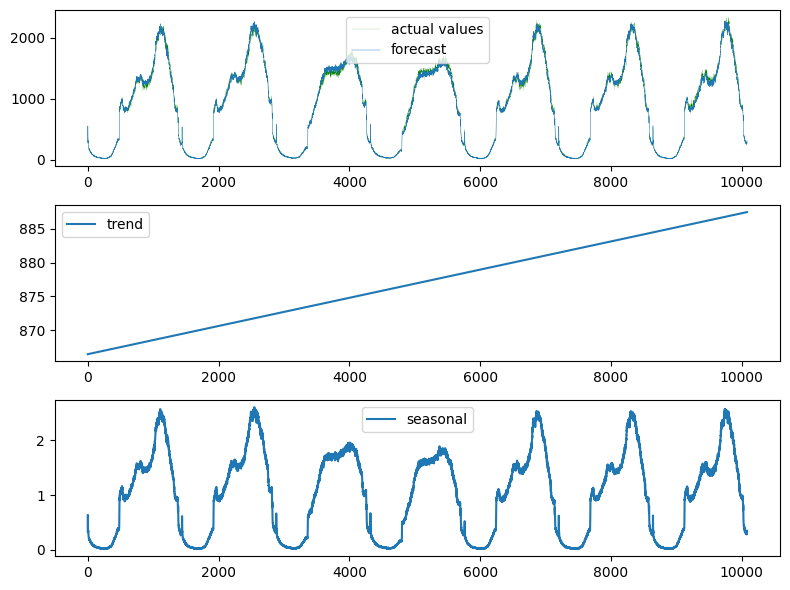

In [469]:
fig, (ax_forecast, ax_trend, ax_seasonal) = plt.subplots(nrows=3, ncols=1, figsize=(8, 2*3))
sns.lineplot(data=test_data[METRIC_ID].values, ax=ax_forecast, label="actual values", c="green", lw=0.1)
sns.lineplot(data=forecast, ax=ax_forecast, label="forecast", lw=0.3)
sns.lineplot(data=trend, ax=ax_trend, label="trend")
sns.lineplot(data=seasonal, ax=ax_seasonal, label="seasonal")
fig.tight_layout();